# Predicting fuel prices with tensorflow
# Tutorial: [Time series prediction with LSTM in Tensorflow](https://medium.com/towards-data-science/time-series-prediction-with-lstm-in-tensorflow-42104db39340)
# Data: [BLS for Developers](https://www.bls.gov/developers/home.htm)

The goal is to build a model that can consistently predict fuel prices (a univariate time-series) using Tensorflow neural networks and Keras

# Import dependencies

In [1]:
# Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from dataclasses import dataclass
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import pickle

In [2]:
# Mount google drive and save this model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper functions

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """Helper function to plot our time series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(False)

def moving_avg(array: list, window_length: int) -> list:
    """Calculates rolling mean of length window_lenght of an array of integers"""
    moving_avg_list = []
    start_idx_window = 0
    end_idx_window = window_length

    while end_idx_window < len(array):
        current_values = array[start_idx_window: end_idx_window]
        current_mean = sum(current_values) / window_length
        moving_avg_list.append(current_mean)
        start_idx_window += 1
        end_idx_window += 1

    return moving_avg_list

def calc_mae(y: list, y_pred: list) -> float:
    """Calculates and returns mae for series y values and predicted values"""
    n = len(y_pred)
    len_diff = len(y) - len(y_pred)
    y = y[len_diff: ]
    currentSum = 0
    for i in range(len(y)):
        currentSum += abs(y[i] - y_pred[i])
    mae = currentSum / n
    return mae

# Data Pipeline

In [4]:
# Iterate through BLS API (limits 20 years per request) at a time
# Start with 1976
# increment until current year (2022)
# 500 daily call limit

class GasPipeline:
    def __init__(self, year_start = 1976, api_key = "7e2ef7c028774d9db144d3f1c78b1023", url = "https://api.bls.gov/publicAPI/v2/timeseries/data/", data_dict = {"period": [], "periodName": [], "value": [], "year": [], "date": []}):
        self.api_key = api_key
        self.url = url
        self.year_start = year_start
        self.data_dict = data_dict

    def get_raw_data(self):

        while self.year_start <= 2023:

            payload = {
                "seriesid": "APU000074714", # series Id
                "registrationkey": self.api_key,
                "startyear": "{}".format(self.year_start),
                "endyear": "{}".format(self.year_start + 1)
                }

            response = requests.post(url=self.url, data=payload)
            raw_data = response.json()
            raw_data = raw_data["Results"]["series"][0]["data"]

            for element in raw_data:
                for item in element:
                    if item != "latest" and item != "footnotes":
                        if item == "value":
                            self.data_dict[item].append(float(element[item]))
                        else:
                            self.data_dict[item].append(element[item])
                    else:
                        continue 

            self.year_start += 2

        return self.data_dict

    def create_date_column(self):
        for (i, j) in zip(self.data_dict["periodName"], self.data_dict["year"]):
            date_formatted = parser.parse(i + " " + "1" + " " + j)
            self.data_dict["date"].append(date_formatted)

    def save_pickle(self, data_dict_filename = "/content/drive/MyDrive/Colab Notebooks/fuel/fuel_prices.p"):
        pickle.dump(self.data_dict, open(data_dict_filename, "wb"))

    def load_pickle(self, data_dict_filename = "/content/drive/MyDrive/Colab Notebooks/fuel/fuel_prices.p"):
        return pickle.load(open(data_dict_filename, "rb"))


In [ ]:
# Run pipeline
etl = GasPipeline()
data_dict = etl.get_raw_data()
etl.create_date_column()
etl.save_pickle()

# Organize and clean
# df = pd.DataFrame(data=data_dict)
# df.sort_values(by=["year", "period"], axis=0, ascending=True, inplace=True)
# df.reset_index(drop=True, inplace=True)
# df['price_change'] = df['value'].diff()
# df.dropna(axis=0, inplace=True)
# df.reset_index(drop=True, inplace=True)

In [8]:
# Load data
etl = GasPipeline()
data_dict = etl.load_pickle()

# Organize and clean
df = pd.DataFrame(data=data_dict)
df.sort_values(by=["year", "period"], axis=0, ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df['price_change'] = df['value'].diff()
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [9]:
df

,period,periodName,value,year,date,price_change
0,M02,February,0.600,1976,1976-02-01,-0.005
1,M03,March,0.594,1976,1976-03-01,-0.006
2,M04,April,0.592,1976,1976-04-01,-0.002
3,M05,May,0.600,1976,1976-05-01,0.008
4,M06,June,0.616,1976,1976-06-01,0.016
...,...,...,...,...,...,...
553,M03,March,4.312,2022,2022-03-01,0.720
554,M04,April,4.271,2022,2022-04-01,-0.041
555,M05,May,4.604,2022,2022-05-01,0.333
556,M06,June,5.058,2022,2022-06-01,0.454


Dataset looks good. Let's save the parameters of our time series in the dataclass

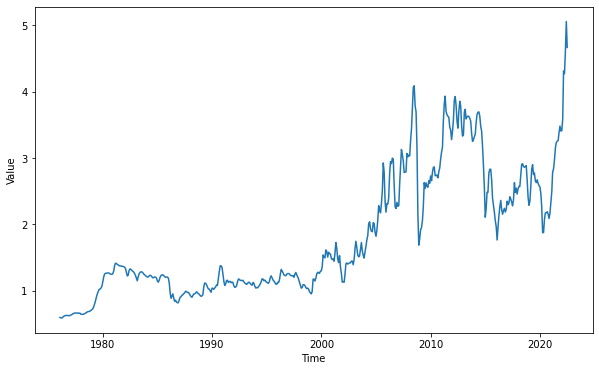

In [10]:
@dataclass
class G:
    TIME, SERIES = df.date.values, df.value.values
    SPLIT_TIME = int(round(len(df) * .8, 0)) # 80% of the data is training data
    WINDOW_SIZE = 20 # how many data points will we take into account to make our prediction
    BATCH_SIZE = 5 # how many examples will we supply per batch
    SHUFFLE_BUFFER_SIZE = 1000 # we need this parameter to define the Tensorflow sample buffer

# Plot the series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show;

# Preprocessing

In [11]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
	"""Divide the time series into training and validation set"""
	time_train = time[:time_step]
	series_train = series[:time_step]
	time_valid = time[time_step:]
	series_valid = series[time_step:]

	return time_train, series_train, time_valid, series_valid

def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
	"""
	We create time windows to create X and y features.
	For example, if we choose a window of 20, we will create a dataset formed by 20 points as X
	"""
	dataset = tf.data.Dataset.from_tensor_slices(series)
	dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
	dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
	dataset = dataset.shuffle(shuffle_buffer)
	dataset = dataset.map(lambda window: (window[:-1], window[-1]))
	dataset = dataset.batch(batch_size).prefetch(1)
	return dataset


In [ ]:
# Let's create the dataset with time windows
dataset = windowed_dataset(G.SERIES)

# Divide into training and validation sets
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

# Baseline model

We need a reference to which our neural network's performance can be compared. For simplicity, let's use a 3-month moving average. This way, we can determine whether or not our model has the predictive power want. The 3-month moving average will smooth out those fluctuation throughout the year. The rolling avergae will also give us an idea of the trend. This is a simple, but workable model.

In [ ]:
n_months = 3
moving_avg = moving_avg(array = G.SERIES, window_length = n_months)
print(G.SERIES[-n_months - 1: ])
print(np.mean(G.SERIES[-n_months - 1: -1]))
print(moving_avg[-1])
np.mean(G.SERIES[-n_months - 1: -1]) == moving_avg[-1]

[4.271 4.604 5.058 4.667]
4.644333333333333
4.644333333333333


True

Predict next month's national average gas price

In [ ]:
# Predict next month's fuel price using Previous n_months fuel prices
# print(G.SERIES[-n_months: ])
forecast_ma = sum(G.SERIES[-n_months: ]) / n_months
print("Next month's forecasted national fuel price is: ${:.2f}".format(forecast_ma))

Next month's forecasted national fuel price is: $4.78


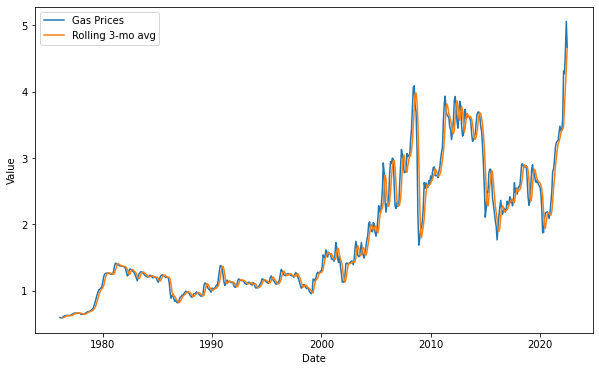

In [ ]:
# Plot the series with the rolling average
plt.figure(figsize=(10, 6))
plt.plot(G.TIME, G.SERIES, label="Gas Prices")
plt.plot(G.TIME[n_months:], moving_avg, label = 'Rolling {}-mo avg'.format(n_months))
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show();

Doesn't look too bad. Let's calculate the mean absolute error of our model. As a refresher, let's recall the mathematical representation of MAE (Mean Absolute Error)

\begin{equation}
MAE=(\frac{1}{n})\sum_{i=1}^{n}\left | y_{i} - \hat{y} \right |
\end{equation}

In [ ]:
simple_model_mae = calc_mae(y = G.SERIES, y_pred = moving_avg)
print(f'MAE using the {n_months}-month moving average model: {simple_model_mae:.4f}')

MAE using the 3-month moving average model: 0.1089


This model is not bad, considering it's a basic model. But let's see if we can improve upon this using a deep learning tensorflow model

# Neural Network Architecture

In [ ]:
def create_uncompiled_model():
    # Define a sequential model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                               input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1)
    ])

    return model

# EarlyStopping callback

In [ ]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):

        if (logs.get('mae') < 0.05):
            print("\nMAE threshold reached. Training stopped.")
            self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

# Model training

In [ ]:
def create_model():
    tf.random.set_seed(51)
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["mae"])
    return model

model_ = create_model()

# We train for 10 epochs and assign the callback
model_history = model_.fit(dataset, epochs=20, callbacks=[early_stopping])

Epoch 1/20
108/108 [==============================] - 17s 34ms/step - loss: 0.1397 - mae: 0.3829
Epoch 2/20
108/108 [==============================] - 4s 33ms/step - loss: 0.0487 - mae: 0.2172
Epoch 3/20
108/108 [==============================] - 4s 33ms/step - loss: 0.0320 - mae: 0.1727
Epoch 4/20
108/108 [==============================] - 4s 33ms/step - loss: 0.0279 - mae: 0.1602
Epoch 5/20
108/108 [==============================] - 4s 33ms/step - loss: 0.0189 - mae: 0.1382
Epoch 6/20
108/108 [==============================] - 4s 34ms/step - loss: 0.0146 - mae: 0.1184
Epoch 7/20
108/108 [==============================] - 4s 34ms/step - loss: 0.0118 - mae: 0.1068
Epoch 8/20
108/108 [==============================] - 4s 33ms/step - loss: 0.0106 - mae: 0.0980
Epoch 9/20
108/108 [==============================] - 4s 33ms/step - loss: 0.0148 - mae: 0.1156
Epoch 10/20
108/108 [==============================] - 4s 33ms/step - loss: 0.0116 - mae: 0.1048
Epoch 11/20
108/108 [=================

In [ ]:
# Save as serialized objects
pickle.dump(model_history, open("/content/drive/MyDrive/Colab Notebooks/fuel/model_history.p", "wb"))
pickle.dump(model_, open("/content/drive/MyDrive/Colab Notebooks/fuel/model_.p", "wb"))

# Load objects using pickle
# model_history = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/fuel/model_history.p", "rb"))
# model_ = pickle.load(open("/content/drive/MyDrive/Colab Notebooks/fuel/model_.p", "rb"))

In [ ]:
model_.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, None, 1)           0         
                                                                 
 bidirectional_20 (Bidirecti  (None, None, 2048)       8404992   
 onal)                                                           
                                                                 
 bidirectional_21 (Bidirecti  (None, None, 1024)       10489856  
 onal)                                                           
                                                                 
 bidirectional_22 (Bidirecti  (None, None, 512)        2623488   
 onal)                                                           
                                                                 
 bidirectional_23 (Bidirecti  (None, None, 256)        656384    
 onal)                                                

# Evaluation of the model

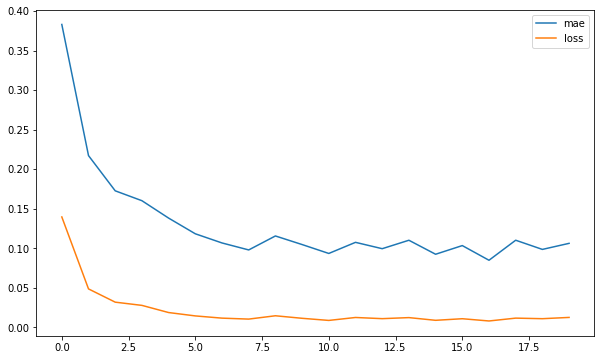

In [ ]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(model_history.history['mae'], label='mae')
plt.plot(model_history.history['loss'], label='loss')
plt.legend()
plt.show();

The curves show an improvement of the net until it stabilizes after about the 10th epoch. Let's calculate MAE and MSE.

In [ ]:
optimal_num_epochs = np.argmin(model_history.history['mae']) + 1
print(optimal_num_epochs)

17


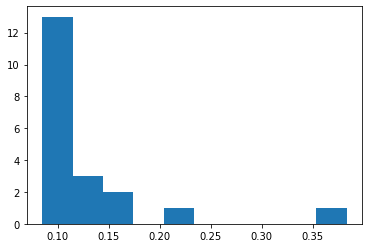

In [ ]:
# Distribution of errors
plt.hist(model_history.history['mae'])
plt.show();

In [ ]:
def compute_metrics(true_series, forecast):
    """Helper function to print MSE and MAE"""
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

def model_forecast(model, series, window_size):
    """
    This function converts the input series
    into a dataset with time windows for forecasting
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift = 1, drop_remainder = True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)

    return forecast

Let's see how it performs. Let's make predictions on the whole series and on the validation set.

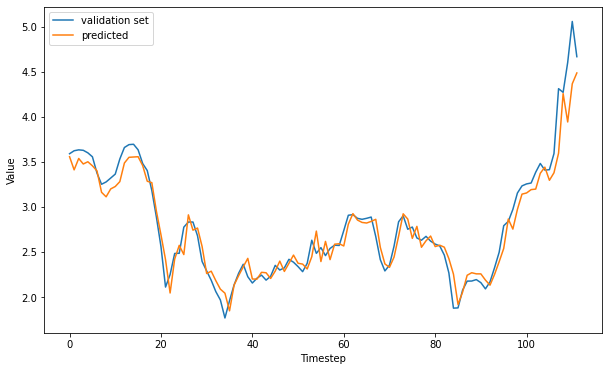

In [ ]:
# Prediction on the whole series
all_forecast = model_forecast(model_, G.SERIES, G.WINDOW_SIZE).squeeze()

# Validation portion
val_forecast = all_forecast[G.SPLIT_TIME - G.WINDOW_SIZE: -1]

# Plot results on the validation set
plt.figure(figsize=(10, 6))
plt.plot(series_valid, label="validation set")
plt.plot(val_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show();

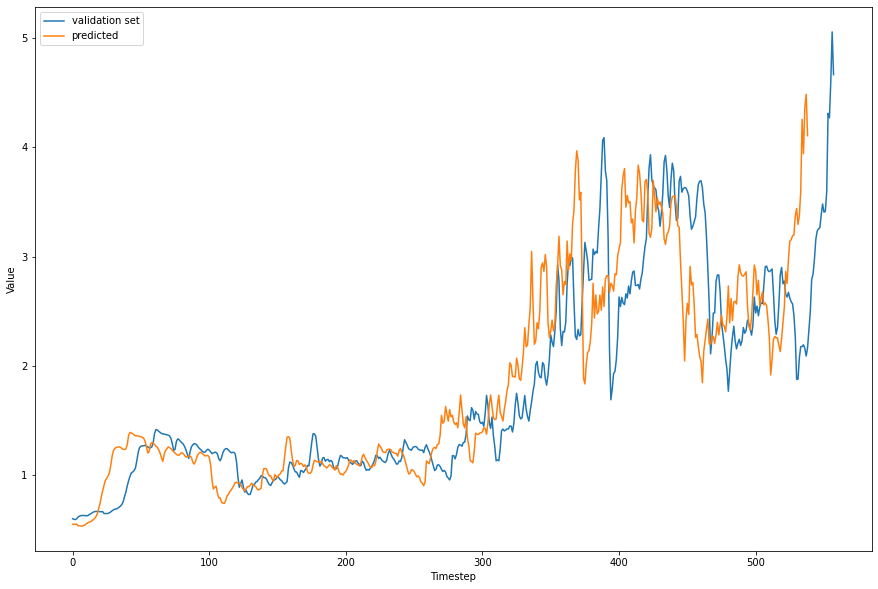

In [ ]:
# Plot the results on the entire series
# Plot results on the validation set
plt.figure(figsize=(15, 10))
plt.plot(G.SERIES, label="validation set")
plt.plot(all_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show();

The results appear to be decent. The predicted series looks to be in line with the actual series

In [ ]:
mse, mae = compute_metrics(series_valid, val_forecast)
print(f'{n_months}-month ma mae: {simple_model_mae:.4f}')
print(f"LSTM mae: {mae:.4f}, LSTM mse: {mse:.4f}")
print(f'An improvement of {simple_model_mae - mae:.4f}')

3-month ma mae: 0.1089
LSTM mae: 0.1194, LSTM mse: 0.0285
An improvement of -0.0105


However, when we look at the MAE, it performs roughly the same as the base model (simple 3-month moving average)

# Predicting a new point in the future

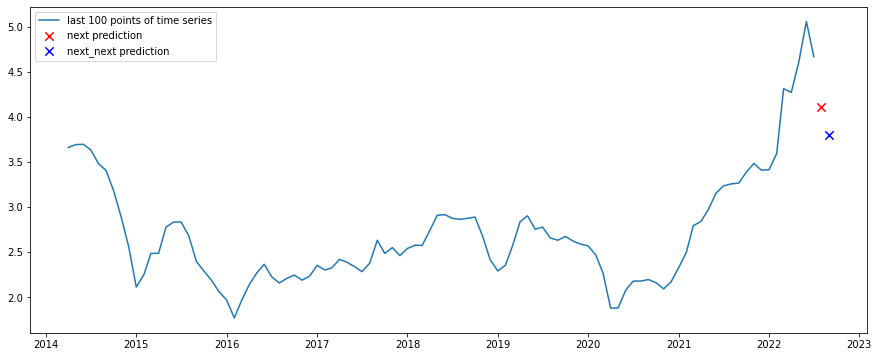

In [ ]:
new_forecast = []
new_forecast_series = G.SERIES[-G.WINDOW_SIZE:]
pred_next = model_.predict(new_forecast_series[np.newaxis])
new_forecast_series = np.append(new_forecast_series, pred_next[0][0])[-G.WINDOW_SIZE:]
pred_next_next = model_.predict(new_forecast_series[np.newaxis])

idx_slicer = 100
pred_period = np.timedelta64(31, 'D')

plt.figure(figsize=(15, 6))
plt.plot(G.TIME[-idx_slicer:], G.SERIES[-idx_slicer:], label='last {} points of time series'.format(idx_slicer))
plt.scatter(max(G.TIME) + pred_period, pred_next, color='red', marker='x', s=70, label='next prediction')
plt.scatter(max(G.TIME) + pred_period + pred_period, pred_next_next, color='blue', marker='x', s=70, label='next_next prediction')
plt.legend()
plt.show();

In [ ]:
print("The forecasted national average price of gas for August 2022 is: ${:.2f}".format(pred_next[0][0]))
print("The forecasted national average price of gas for September 2022 is: ${:.2f}".format(pred_next_next[0][0]))

The forecasted national average price of gas for August 2022 is: $4.11
The forecasted national average price of gas for September 2022 is: $3.79


# Analysis of results

In [ ]:
print("Error:")
print(f"mse: {mse:.4f}, mae: {mae:.4f}")
print("An mse of {:.4f} implies the fitted line is very close to the actual data points.\nAn mae of {:.4f} implies the model is off by an average of ${:.2f}.\n".format(mse, mae, mae))
print("Training epochs and loss curves:")
print("The neural network loss improves as we iterate epochs,\nwith stabilization ocurring after the {}th epoch.\nAdditional training after that will risk overfitting.\nLooking at the loss curves, when the training loss and validation loss\nstarting moving apart, you know you are overfitting.\n".format(optimal_num_epochs))
print("Areas for improvement:")
print("1. Re-train model with {} epochs".format(optimal_num_epochs))
print("2. Re-train model with engineered features such as moving average and month/year")

Error:
mse: 0.0285, mae: 0.1194
An mse of 0.0285 implies the fitted line is very close to the actual data points.
An mae of 0.1194 implies the model is off by an average of $0.12.

Training epochs and loss curves:
The neural network loss improves as we iterate epochs,
with stabilization ocurring after the 17th epoch.
Additional training after that will risk overfitting.
Looking at the loss curves, when the training loss and validation loss
starting moving apart, you know you are overfitting.

Areas for improvement:
1. Re-train model with 17 epochs
2. Re-train model with engineered features such as moving average and month/year


# Conclusion 1
Here's summary of our project:
1. Used a data pipeline to generate fuel prices from 1976 to the current period
2. Divided the series into X and y appropriately
3. Developed a neural network in Keras and Tensorflow based on bidirectional LSTMs
4. Trained our model with early stopping
5. Evaluated performance
6. Made a prediction for July 2022's gas price

# Feature Engineering
1. Engineer new features
    - moving average of price
    - moving average of price volatility (returns)
2. Prepare data for ingestion
3. Prepare model for training
4. Re-train with 10 epochs